In [120]:
import numpy
import corner
import emcee
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import scipy.optimize
import sys
import numpy as np
from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS
import scipy.optimize as op
from astropy.constants import c
import functions_polarization_MCMC as mcmc
import function_plots as mcmc_plots
from importlib import reload
import time
import tqdm 

import scipy.stats
import math
from astropy.coordinates import Angle
from astropy.coordinates import SkyCoord

In [2]:
# Importing data:
path_git = r'/net/vdesk/data2/GoesaertW/Data_Analyis_Git/'
rsl = fits.open(get_pkg_data_filename(path_git+'Abell85_catalog_BDSF_adapbox_rsl.fits'))[1].data

path_rmsynth = r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/rmsynth/'
fname_polint = 'rmsynth_polint_1'
hdu_polint = fits.open(get_pkg_data_filename(path_rmsynth+fname_polint+'.fits'))[0]
del hdu_polint.header['CROTA4']
data_polint = hdu_polint.data
wcs = WCS(hdu_polint.header)

savedir =r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/Photometry_BDSF/'

freqs = np.load('MKT_Freqs_mid.npy')

lamb = c.value/freqs

flux_measurements_I = np.load(savedir+'Abell85_BDSF_I.npy')
flux_measurements_Q = np.load(savedir+'Abell85_BDSF_Q.npy')
flux_measurements_U = np.load(savedir+'Abell85_BDSF_U.npy')
flux_unc_I = np.load(savedir+'Abell85_BDSF_unc_I.npy')
flux_unc_Q = np.load(savedir+'Abell85_BDSF_unc_Q.npy')
flux_unc_U = np.load(savedir+'Abell85_BDSF_unc_U.npy')
sources_phi = np.load(savedir+'Abell85_phi.npy')
mask = np.load(r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/'+'Abell85_mask_5sigma10pix.npy')

I_select = flux_measurements_I[:,mask]
Q_select = flux_measurements_Q[:,mask]
U_select = flux_measurements_U[:,mask]
I_unc_select = flux_unc_I[:,mask]
Q_unc_select = flux_unc_Q[:,mask]
U_unc_select = flux_unc_U[:,mask]
phi_select = sources_phi[mask]
rsl_select = rsl[mask]

angles_select = 0.5*np.arctan2(U_select, Q_select)
angles_select_err = np.sqrt((Q_select*U_unc_select)**2 + (U_select*Q_unc_select)**2)/(2*(U_select**2 + Q_select**2))
linpol_select = np.sqrt(U_select**2 + Q_select**2)
linpol_select_err = (U_select*U_unc_select + Q_select*Q_unc_select)/linpol_select
p_select = linpol_select/I_select
p_select_err = p_select*np.sqrt((0*linpol_select_err/linpol_select)**2 + (I_unc_select/I_select)**2)

directory = r'/net/vdesk/data2/GoesaertW/Meerkat_Data/Abell_85/'
norm_list = np.load(directory+'Abell85_mcmc_Inorm.npy')
spix_list = np.load(directory+'Abell85_mcmc_Ispix.npy')
curv_list = np.load(directory+'Abell85_mcmc_Icurv.npy')
p0_list = np.load(directory+'Abell85_mcmc_p0.npy')
chi0_list = np.load(directory+'Abell85_mcmc_chi0.npy')
RM_list = np.load(directory+'Abell85_mcmc_RM.npy')
sigma_list = np.load(directory+'Abell85_mcmc_sigma.npy')
redchisq_QU_list = np.load(directory+'Abell85_mcmc_QUchisqw.npy')
redchisq_I_list = np.load(directory+'Abell85_mcmc_Ichisqw.npy')

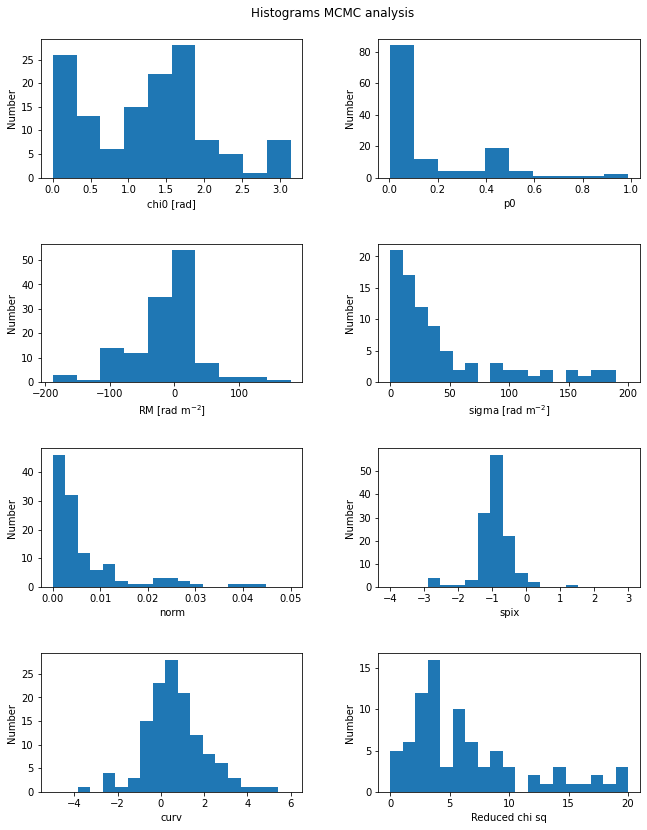

In [3]:
fig, axs = plt.subplots(4, 2)
fig.set_size_inches(10, 12)
fig.tight_layout(pad=4.5)
fig.suptitle('Histograms MCMC analysis')

axs[0,0].hist(chi0_list[:,0])
axs[0,0].set_ylabel('Number')
axs[0,0].set_xlabel('chi0 [rad]')

axs[0,1].hist(p0_list[:,0])
axs[0,1].set_ylabel('Number')
axs[0,1].set_xlabel('p0')

axs[1,0].hist(RM_list[:,0])
axs[1,0].set_ylabel('Number')
axs[1,0].set_xlabel(r'RM [rad m$^{-2}$]')

axs[1,1].hist(sigma_list[:,0], bins=np.linspace(0,200,20))
axs[1,1].set_ylabel('Number')
axs[1,1].set_xlabel(r'sigma [rad m$^{-2}$]')

axs[2,0].hist(norm_list[:,0], bins=np.linspace(0,0.05,20))
axs[2,0].set_ylabel('Number')
axs[2,0].set_xlabel(r'norm')

axs[2,1].hist(spix_list[:,0], bins=np.linspace(-4,3,20))
axs[2,1].set_ylabel('Number')
axs[2,1].set_xlabel(r'spix')

axs[3,0].hist(curv_list[:,0], bins=np.linspace(-5,6 ,20))
axs[3,0].set_ylabel('Number')
axs[3,0].set_xlabel(r'curv')

axs[3,1].hist(redchisq_QU_list, bins=np.linspace(0,20,20))
axs[3,1].set_ylabel('Number')
axs[3,1].set_xlabel('Reduced chi sq')
plt.show()

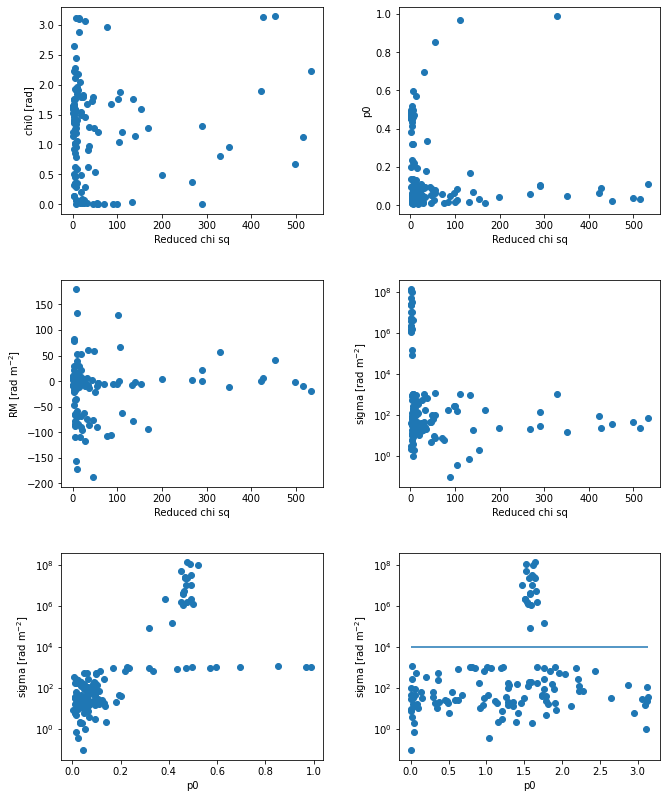

In [15]:
fig, axs = plt.subplots(3, 2)
fig.set_size_inches(10, 12)
fig.tight_layout(pad=4.5)

axs[0,0].scatter(redchisq_QU_list, chi0_list[:,0])
axs[0,0].set_xlabel('Reduced chi sq')
axs[0,0].set_ylabel('chi0 [rad]')

axs[0,1].scatter(redchisq_QU_list, p0_list[:,0])
axs[0,1].set_xlabel('Reduced chi sq')
axs[0,1].set_ylabel('p0')

axs[1,0].scatter(redchisq_QU_list, RM_list[:,0])
axs[1,0].set_xlabel('Reduced chi sq')
axs[1,0].set_ylabel('RM [rad m$^{-2}$]')

axs[1,1].scatter(redchisq_QU_list, sigma_list[:,0])
axs[1,1].set_xlabel('Reduced chi sq')
axs[1,1].set_ylabel('sigma [rad m$^{-2}$]')
axs[1,1].set_yscale('log')

axs[2,0].scatter(p0_list[:,0], sigma_list[:,0])
axs[2,0].set_xlabel('p0')
axs[2,0].set_ylabel('sigma [rad m$^{-2}$]')
axs[2,0].set_yscale('log')

axs[2,1].scatter(chi0_list[:,0], sigma_list[:,0])
axs[2,1].hlines(1e4, 0, np.pi)
axs[2,1].set_xlabel('p0')
axs[2,1].set_ylabel('sigma [rad m$^{-2}$]')
axs[2,1].set_yscale('log')

plt.show()

# Flagging:

In [235]:
sigma = 8
conf_int = scipy.stats.chi2.cdf(sigma**2,1)
red_chi_lim = scipy.stats.chi2.ppf(conf_int, 20)/20
print('reduced chisqw at 5 sigma is: ' + str(red_chi_lim))

mask_inspec = np.argwhere((sigma_list[:,0]<400)&(redchisq_QU_list < 25)&(p0_list[:,0]<0.15))#&(np.abs(RM_list[:,0]) < 200))
print(len(mask_inspec))

reduced chisqw at 5 sigma is: 5.829015193547232
50


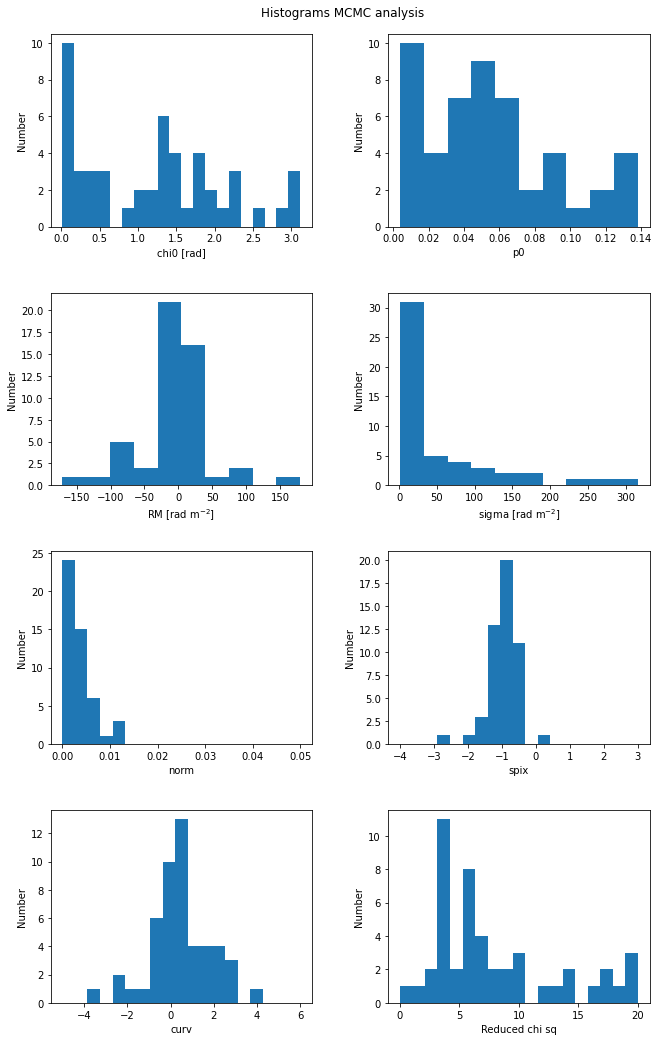

In [236]:
fig, axs = plt.subplots(4, 2)
fig.set_size_inches(10, 15)
fig.tight_layout(pad=4.5)

fig.suptitle('Histograms MCMC analysis')

axs[0,0].hist(chi0_list[mask_inspec,0], bins=20)
axs[0,0].set_ylabel('Number')
axs[0,0].set_xlabel('chi0 [rad]')

axs[0,1].hist(p0_list[mask_inspec,0])
axs[0,1].set_ylabel('Number')
axs[0,1].set_xlabel('p0')

axs[1,0].hist(RM_list[mask_inspec,0])
axs[1,0].set_ylabel('Number')
axs[1,0].set_xlabel(r'RM [rad m$^{-2}$]')

axs[1,1].hist(sigma_list[mask_inspec,0])#, bins=np.linspace(0,200,20))
axs[1,1].set_ylabel('Number')
axs[1,1].set_xlabel(r'sigma [rad m$^{-2}$]')

axs[2,0].hist(norm_list[mask_inspec,0], bins=np.linspace(0,0.05,20))
axs[2,0].set_ylabel('Number')
axs[2,0].set_xlabel(r'norm')

axs[2,1].hist(spix_list[mask_inspec,0], bins=np.linspace(-4,3,20))
axs[2,1].set_ylabel('Number')
axs[2,1].set_xlabel(r'spix')

axs[3,0].hist(curv_list[mask_inspec,0], bins=np.linspace(-5,6 ,20))
axs[3,0].set_ylabel('Number')
axs[3,0].set_xlabel(r'curv')

axs[3,1].hist(redchisq_QU_list[mask_inspec], bins=np.linspace(0,20,20))
axs[3,1].set_ylabel('Number')
axs[3,1].set_xlabel('Reduced chi sq')
plt.show()

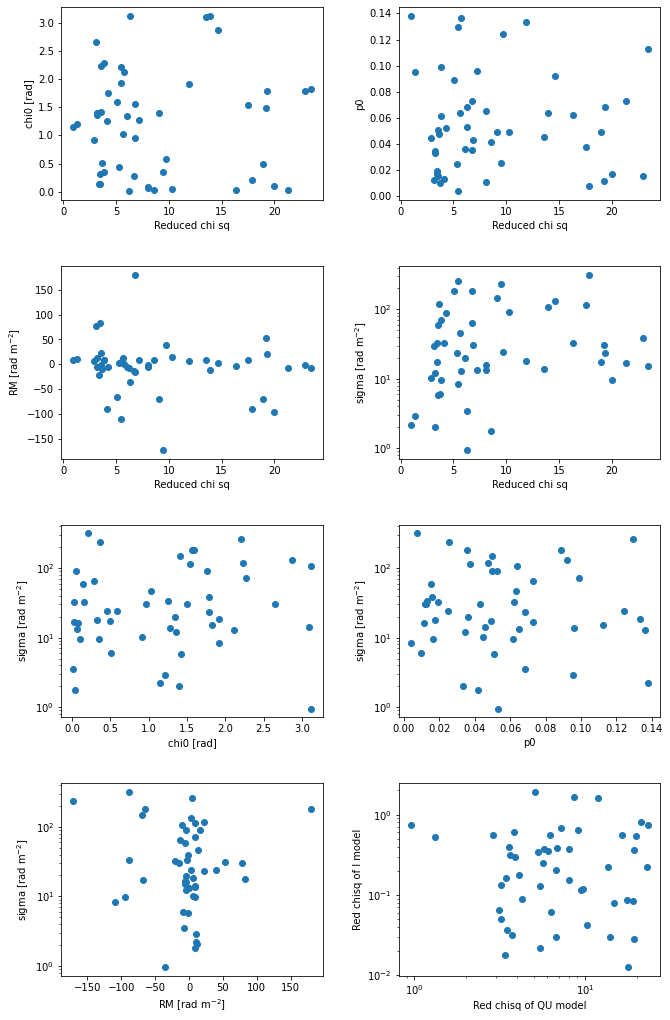

In [237]:
fig, axs = plt.subplots(4, 2)
fig.set_size_inches(10, 15)
fig.tight_layout(pad=4.5)

axs[0,0].scatter(redchisq_QU_list[mask_inspec], chi0_list[mask_inspec,0])
axs[0,0].set_xlabel('Reduced chi sq')
axs[0,0].set_ylabel('chi0 [rad]')

axs[0,1].scatter(redchisq_QU_list[mask_inspec], p0_list[mask_inspec,0])
axs[0,1].set_xlabel('Reduced chi sq')
axs[0,1].set_ylabel('p0')

axs[1,0].scatter(redchisq_QU_list[mask_inspec], RM_list[mask_inspec,0])
axs[1,0].set_xlabel('Reduced chi sq')
axs[1,0].set_ylabel('RM [rad m$^{-2}$]')

axs[1,1].scatter(redchisq_QU_list[mask_inspec], sigma_list[mask_inspec,0])
axs[1,1].set_xlabel('Reduced chi sq')
axs[1,1].set_ylabel('sigma [rad m$^{-2}$]')
axs[1,1].set_yscale('log')

axs[2,0].scatter(chi0_list[mask_inspec,0], sigma_list[mask_inspec,0])
axs[2,0].set_xlabel('chi0 [rad]')
axs[2,0].set_ylabel('sigma [rad m$^{-2}$]')
axs[2,0].set_yscale('log')

axs[2,1].scatter(p0_list[mask_inspec,0], sigma_list[mask_inspec,0])
axs[2,1].set_xlabel('p0')
axs[2,1].set_ylabel('sigma [rad m$^{-2}$]')
axs[2,1].set_yscale('log')

axs[3,0].scatter(RM_list[mask_inspec,0], sigma_list[mask_inspec,0])
axs[3,0].set_xlabel('RM [rad m$^{-2}$]')
axs[3,0].set_ylabel('sigma [rad m$^{-2}$]')
axs[3,0].set_yscale('log')

axs[3,1].scatter(redchisq_QU_list[mask_inspec], redchisq_I_list[mask_inspec])
axs[3,1].set_xlabel('Red chisq of QU model')
axs[3,1].set_ylabel('Red chisq of I model')
axs[3,1].set_xscale('log')
axs[3,1].set_yscale('log')

plt.show()

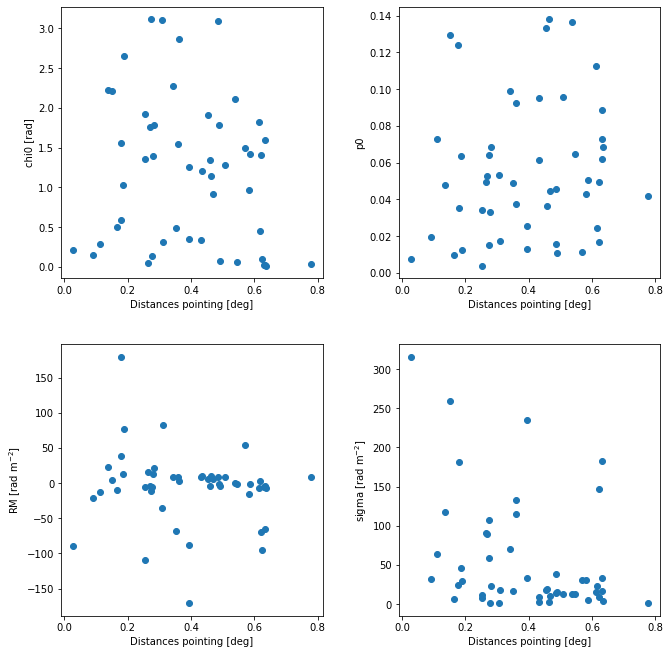

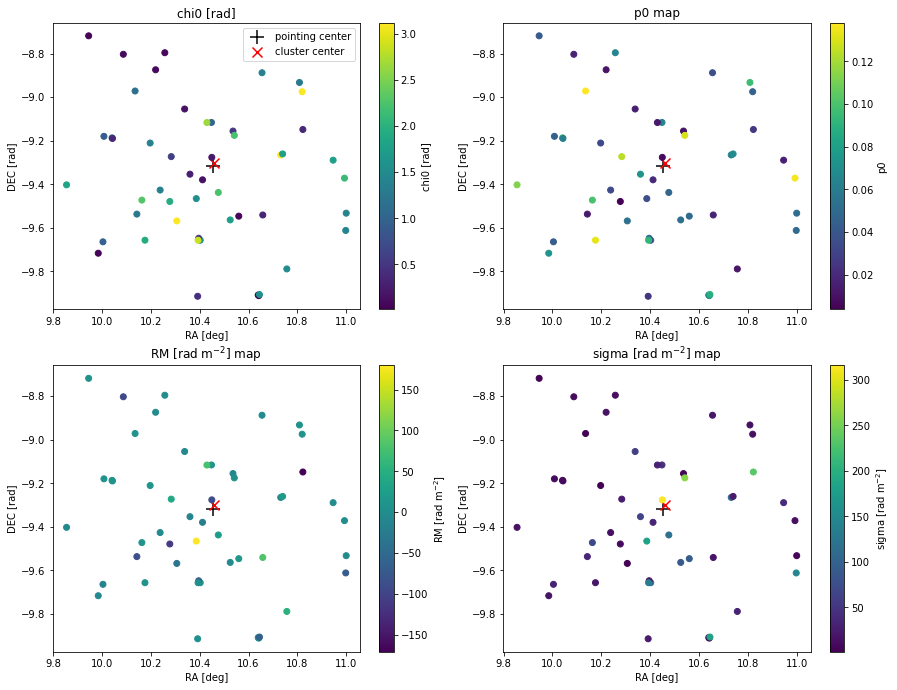

In [238]:
sources_worldpos = np.array((rsl['RA'], rsl['DEC']))
sources_pixpos_floats = wcs.all_world2pix(rsl['RA'], rsl['DEC'], 0)
sources_pixpos = np.swapaxes(np.rint(sources_pixpos_floats\
                                     , out=np.zeros(np.shape(sources_worldpos)
                                     , int), casting='unsafe'),0,1)

wcs_new = wcs.celestial

loc_world_selected = wcs_new.pixel_to_world(sources_pixpos[mask,0], sources_pixpos[mask,1]).data
point_center = wcs_new.pixel_to_world(3617/2, 3617/2)

cluster_ra = Angle('0:41:50.390 hours')
cluster_dec = Angle('-9:18:09.53 degrees')
cluster_center = SkyCoord(ra=cluster_ra, dec=cluster_dec, frame='icrs')
cluster_center_pixpos = wcs.all_world2pix(cluster_ra, cluster_dec, 0)

#print(point_center)
#print(cluster_center)

distances_pointing = np.sqrt((loc_world_selected.lon.degree-point_center.data.lon.degree)**2+(loc_world_selected.lat.degree-point_center.data.lat.degree)**2) #This is an approximation
distances_cluster = np.sqrt((loc_world_selected.lon.degree-cluster_center.data.lon.degree)**2+(loc_world_selected.lat.degree-cluster_center.data.lat.degree)**2) #This is an approximation

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(10, 10)
fig.tight_layout(pad=4.5)

axs[0,0].scatter(distances_cluster[mask_inspec], chi0_list[mask_inspec,0])
axs[0,0].set_xlabel('Distances pointing [deg]')
axs[0,0].set_ylabel('chi0 [rad]')

axs[0,1].scatter(distances_cluster[mask_inspec], p0_list[mask_inspec,0])
axs[0,1].set_xlabel('Distances pointing [deg]')
axs[0,1].set_ylabel('p0')

axs[1,0].scatter(distances_cluster[mask_inspec], RM_list[mask_inspec,0])
axs[1,0].set_xlabel('Distances pointing [deg]')
axs[1,0].set_ylabel('RM [rad m$^{-2}$]')

axs[1,1].scatter(distances_cluster[mask_inspec], sigma_list[mask_inspec,0])
axs[1,1].set_xlabel('Distances pointing [deg]')
axs[1,1].set_ylabel('sigma [rad m$^{-2}$]')

plt.show()


fig, axs = plt.subplots(2, 2)
fig.set_size_inches(13,10)
fig.tight_layout(pad=3.5)

axs[0,0].set_title('chi0 [rad]')
img1 = axs[0,0].scatter(loc_world_selected.lon.degree[mask_inspec], loc_world_selected.lat.degree[mask_inspec]\
                 , c=chi0_list[mask_inspec,0], zorder=2)
axs[0,0].scatter(point_center.data.lon.degree, point_center.data.lat.degree, color='black'\
                 , marker='+', s=2e2, label='pointing center')
axs[0,0].scatter(cluster_center.data.lon.degree, cluster_center.data.lat.degree, color='red'\
                 , marker='x', s=1e2, label='cluster center')
axs[0,0].set_xlabel('RA [deg]')
axs[0,0].set_ylabel('DEC [rad]')
axs[0,0].legend()
plt.colorbar(img1, ax=axs[0,0], orientation='vertical', label='chi0 [rad]')

axs[0,1].set_title('p0 map')
img2 = axs[0,1].scatter(loc_world_selected.lon.degree[mask_inspec], loc_world_selected.lat.degree[mask_inspec]\
                 , c=p0_list[mask_inspec,0], zorder=2)
axs[0,1].scatter(point_center.data.lon.degree, point_center.data.lat.degree, color='black'\
                 , marker='+', s=2e2)
axs[0,1].scatter(cluster_center.data.lon.degree, cluster_center.data.lat.degree, color='red'\
                 , marker='x', s=1e2)
axs[0,1].set_xlabel('RA [deg]')
axs[0,1].set_ylabel('DEC [rad]')
plt.colorbar(img2, ax=axs[0,1], orientation='vertical', label='p0')

axs[1,0].set_title('RM [rad m$^{-2}$] map')
img3 = axs[1,0].scatter(loc_world_selected.lon.degree[mask_inspec], loc_world_selected.lat.degree[mask_inspec]\
                 , c=RM_list[mask_inspec,0], zorder=2)
axs[1,0].scatter(point_center.data.lon.degree, point_center.data.lat.degree, color='black', marker='+', s=2e2)
axs[1,0].scatter(cluster_center.data.lon.degree, cluster_center.data.lat.degree, color='red', marker='x', s=1e2)
axs[1,0].set_xlabel('RA [deg]')
axs[1,0].set_ylabel('DEC [rad]')
plt.colorbar(img3, ax=axs[1,0], orientation='vertical', label='RM [rad m$^{-2}$]')

axs[1,1].set_title('sigma [rad m$^{-2}$] map')
img4 = axs[1,1].scatter(loc_world_selected.lon.degree[mask_inspec], loc_world_selected.lat.degree[mask_inspec]\
                 , c=sigma_list[mask_inspec,0], zorder=2)
axs[1,1].scatter(point_center.data.lon.degree, point_center.data.lat.degree, color='black', marker='+', s=2e2)
axs[1,1].scatter(cluster_center.data.lon.degree, cluster_center.data.lat.degree, color='red', marker='x', s=1e2)
axs[1,1].set_xlabel('RA [deg]')
axs[1,1].set_ylabel('DEC [rad]')
plt.colorbar(img4, ax=axs[1,1], orientation='vertical', label='sigma [rad m$^{-2}$]')

plt.show()

# Model visualization:

In [239]:
#To visualize:
def models(x_local, p0, X0, RM, sigma, norm, a, curv):
    freq = (c.value/np.sqrt(x_local))*1.e-9

    mod_i = norm * freq**(a + curv*np.log10(freq))

    f = np.exp(-2*(sigma**2)*(x_local**2))
       
    mod_q = p0*f*mod_i *np.cos(2.* (X0 + RM*x_local))
    mod_u = p0*f*mod_i *np.sin(2.* (X0 + RM*x_local))
    
    mod_p = np.sqrt(mod_q**2 + mod_u**2) / mod_i
    
    return(mod_q, mod_u, mod_p)

1519943359.375


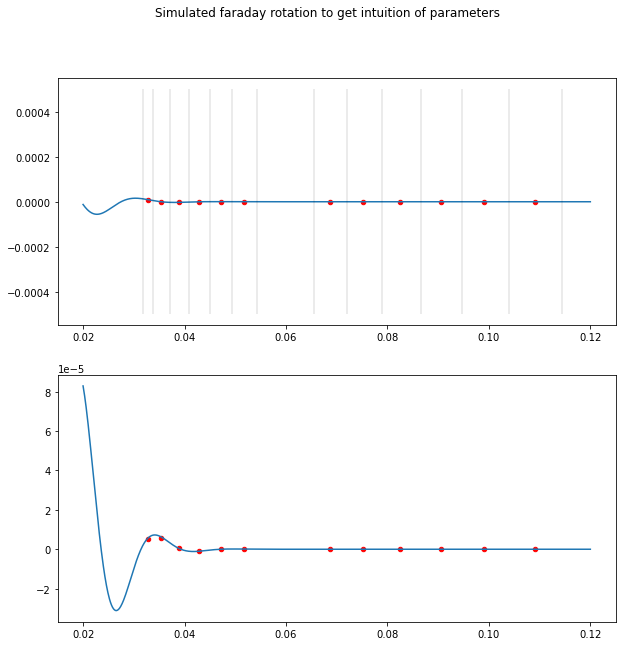

In [240]:
x = np.linspace(0.02, 0.12, 1000)
x_sim = np.flip(lamb)**2
freqs_low = np.load('MKT_Freqs_low.npy')
freqs_high = np.load('MKT_Freqs_up.npy')
lamb_high = np.flip(c.value/freqs_low)
lamb_low = np.flip(c.value/freqs_high)

print(freqs[9])
bin_edges_1 = np.append(lamb_low[:6], lamb_high[5])**2
bin_edges_2 = np.append(lamb_low[6:], lamb_high[-1])**2
bin_edges = np.append(bin_edges_1, bin_edges_2)

norm, spix, curv = 5e-3, -1, 1
p0, X0, RM, sigma = 0.1, 0, 200, 40

model_q, model_u,_ = models(x, p0, X0, RM, sigma, norm, spix, curv)

model_q_sim_1,_,_ = scipy.stats.binned_statistic(x, model_q, statistic='mean', bins=bin_edges_1\
                                               , range=(np.min(bin_edges_1), np.max(bin_edges_1)))
model_q_sim_2,_,_ = scipy.stats.binned_statistic(x, model_q, statistic='mean', bins=bin_edges_2\
                                               , range=(np.min(bin_edges_2), np.max(bin_edges_2)))
model_q_sim = np.append(model_q_sim_1, model_q_sim_2)

model_u_sim_1,_,_ = scipy.stats.binned_statistic(x, model_u, statistic='mean', bins=bin_edges_1\
                                               , range=(np.min(bin_edges_1), np.max(bin_edges_1)))
model_u_sim_2,_,_ = scipy.stats.binned_statistic(x, model_u, statistic='mean', bins=bin_edges_2\
                                               , range=(np.min(bin_edges_2), np.max(bin_edges_2)))
model_u_sim = np.append(model_u_sim_1, model_u_sim_2)

fig, axs = plt.subplots(2, figsize=(10,10))
fig.suptitle('Simulated faraday rotation to get intuition of parameters')
axs[0].plot(x, model_q)
axs[0].scatter(x_sim, model_q_sim, color='red', s=20)
axs[0].vlines(bin_edges, -5e-4, 5e-4, color='black', alpha=0.1)

axs[1].plot(x, model_u)
axs[1].scatter(x_sim, model_u_sim, color='red', s=20)
plt.show()

# Calculate p_1.5Ghz

In [241]:
x15 = (c.value/1.5e9)**2
p15 = np.zeros(len(norm_list))

for n in range(len(norm_list)):
    _,_,p15[n] = models(x15, p0_list[n, 0], chi0_list[n, 0], RM_list[n, 0], sigma_list[n, 0], norm_list[n, 0], spix_list[n, 0], curv_list[n, 0])

depol_rat = p15/p0_list[:,0]
depol_rat_data = p_select[6,:]/p0_list[:,0]

<ipython-input-239-24245696d35b>:12: RuntimeWarning: invalid value encountered in double_scalars
  mod_p = np.sqrt(mod_q**2 + mod_u**2) / mod_i


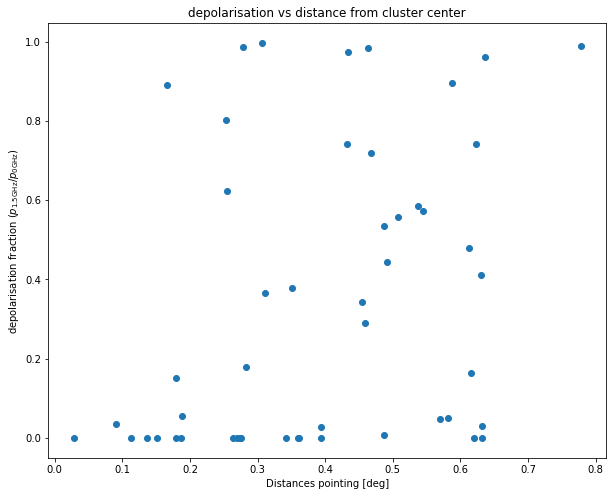

In [242]:
plt.figure(figsize=(10,8))
plt.title('depolarisation vs distance from cluster center')
#plt.scatter(distances_cluster[mask_inspec], depol_rat_data[mask_inspec])
plt.scatter(distances_cluster[mask_inspec], depol_rat[mask_inspec])
plt.xlabel('Distances pointing [deg]')
plt.ylabel('depolarisation fraction ($p_{1.5\mathrm{GHz}}$/$p_{0\mathrm{GHz}}$)')
plt.show()